# Brief demo working with imaging datasets from JWST NIRCam

This notebook is intended to provide a *very* brief introduction working with low-level data products taken in the imaging mode with the JWST NIRCam instrument.  These examples won't get you very close to doing *science* with the JWST images, but they will give you an idea of how more raw data are processed into the deep, multi-wavelength images used for many of the recent JWST discoveries.

There are comprehensive notebooks outlining all of the `jwst` pipeline processing steps for many of the different JWST observing modes provided by STScI at https://github.com/spacetelescope/jwst-pipeline-notebooks/tree/main/notebooks.

<a href="https://colab.research.google.com/github/gbrammer/voss-2025-jwst-data/blob/master/Notebooks/voss2025-jwst-imaging.ipynb"> <img src="https://colab.research.google.com/assets/colab-badge.svg"> </a>


## Install prerequesites

Restart the notebook if the cell below executes and installs the necessary package prerequesites, i.e., on Google Colab.

In [1]:
try:
    import jwst
except ImportError:
    ! pip install "jwst==1.18" mastquery sregion sep


## Directories for pipline reference files from the CRDS system

See https://jwst-crds.stsci.edu/.

In [5]:
import os

env = {
    'CRDS_PATH': '/tmp/crds_cache',
    'CRDS_SERVER_URL': 'https://jwst-crds.stsci.edu'
}
for k in env:
    if os.getenv(k) is None:
        print(f'set {k} = {env[k]}')
        os.environ[k] = env[k]

## Module imports

In [26]:
import glob
import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
import astropy.wcs as pywcs

import jwst
import jwst.datamodels

import mastquery.jwst
import mastquery.utils

import sregion
import sep


## Query MAST for exposures

Query for NIRCam data of the MACS0723 galaxy cluster from the JWST Early Release Observations (program [DD-2736](https://www.stsci.edu/jwst-program-info/program/?program=2736)).

In [9]:
instruments = [
    # 'MIR', ## MIRI
    'NRC',   ## NIRCam
    # 'NIS', ## NIRISS
    # 'NRS', ## NIRSpec
]

filters = []

# Observing program
filters += mastquery.jwst.make_program_filter([2736])

# Query all product levels
filters += mastquery.jwst.make_query_filter('productLevel', values=['1a','1b','2a','2b'])

# Just F200W-CLEAR
filters += mastquery.jwst.make_query_filter('filter', values=['F200W'])

# File extensions
extensions = ['rate','cal','rateints','uncal']

mast = mastquery.jwst.query_all_jwst(
    instruments=instruments,
    # recent_days=days,
    filters=filters,
    columns='*',
    extensions=extensions,
    fix=True
)


ERROR! Session/line number was not unique in database. History logging moved to new session 3788


In [10]:
print(f"Found {len(mast)} rows for the query")

Found 72 rows for the query


In [13]:
for c in ['detector', 'productLevel', 'filter', 'pupil', 'targname']:
    print(np.unique(mast[c]))

detector
--------
   NRCA1
   NRCA2
   NRCA3
   NRCA4
   NRCB1
   NRCB2
   NRCB3
   NRCB4
productLevel
------------
          2b
 filter 
--------
NC.F200W
pupil
-----
CLEAR
     targname     
------------------
SMACS J0723.3-7327


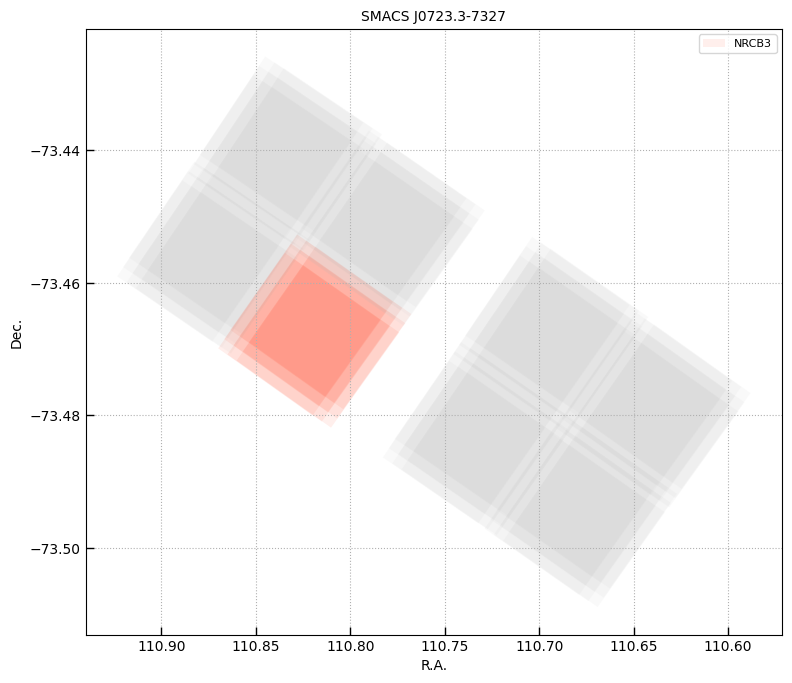

In [25]:
# Plot the exposure footprints

fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax.scatter(mast['ra'], mast['dec'], marker='x', color='0.8', alpha=0.0)

count = 0

for row in mast:
    sr = sregion.SRegion(row['footprint'])

    label = None
    if row['detector'] == 'NRCB3':
        count += 1
        if count == 1:
            label = 'NRCB3'
        
    sr.add_patch_to_axis(
        ax,
        fc='tomato' if row['detector'] == 'NRCB3' else '0.8',
        ec='None',
        alpha=0.1,
        label = label,
    )

ax.legend(fontsize=8)
ax.set_title(mast['targname'][0])
ax.set_aspect(1./np.cos(mast['dec'][0]/180*np.pi))
ax.set_xlim(ax.get_xlim()[::-1])
ax.grid()
ax.set_xlabel('R.A.')
ax.set_ylabel('Dec.')
fig.tight_layout(pad=1)

## Download files from MAST

Download `cal` extension files from the NRCB3 detector and one `uncal` ramp file.

In [36]:
subset = mast['detector'] == 'NRCB3'
print(mast['dataURI'][subset])

                         dataURI                          
----------------------------------------------------------
mast:JWST/product/jw02736001001_02105_00001_nrcb3_cal.fits
mast:JWST/product/jw02736001001_02105_00002_nrcb3_cal.fits
mast:JWST/product/jw02736001001_02105_00003_nrcb3_cal.fits
mast:JWST/product/jw02736001001_02105_00004_nrcb3_cal.fits
mast:JWST/product/jw02736001001_02105_00005_nrcb3_cal.fits
mast:JWST/product/jw02736001001_02105_00006_nrcb3_cal.fits
mast:JWST/product/jw02736001001_02105_00007_nrcb3_cal.fits
mast:JWST/product/jw02736001001_02105_00008_nrcb3_cal.fits
mast:JWST/product/jw02736001001_02105_00009_nrcb3_cal.fits


In [39]:
response = mastquery.utils.download_from_mast(mast[subset])
response

2025-06-03 13:36:34,968 - stpipe - INFO - MAST API token accepted, welcome Gabriel Brammer


INFO: MAST API token accepted, welcome Gabriel Brammer [astroquery.mast.auth]


{'jw02736001001_02105_00001_nrcb3_cal.fits': ('EXISTS', None, None),
 'jw02736001001_02105_00002_nrcb3_cal.fits': ('EXISTS', None, None),
 'jw02736001001_02105_00003_nrcb3_cal.fits': ('EXISTS', None, None),
 'jw02736001001_02105_00004_nrcb3_cal.fits': ('EXISTS', None, None),
 'jw02736001001_02105_00005_nrcb3_cal.fits': ('EXISTS', None, None),
 'jw02736001001_02105_00006_nrcb3_cal.fits': ('EXISTS', None, None),
 'jw02736001001_02105_00007_nrcb3_cal.fits': ('EXISTS', None, None),
 'jw02736001001_02105_00008_nrcb3_cal.fits': ('EXISTS', None, None),
 'jw02736001001_02105_00009_nrcb3_cal.fits': ('EXISTS', None, None)}

In [44]:
# Download one uncal file
uncal_file = os.path.basename(mast[subset]['dataURI'][0].replace('_cal', '_uncal'))
response = mastquery.utils.download_from_mast([uncal_file])
response

2025-06-03 13:43:40,889 - stpipe - INFO - MAST API token accepted, welcome Gabriel Brammer


INFO: MAST API token accepted, welcome Gabriel Brammer [astroquery.mast.auth]


{'jw02736001001_02105_00001_nrcb3_uncal.fits': ('EXISTS', None, None)}

## Look at the counts "up the ramp" in an `uncal` cube`

In [45]:
# Just run the first Level1 pipeline step on the raw `uncal` file
from jwst.group_scale import GroupScaleStep

with jwst.datamodels.open(uncal_file) as dm:
    group = GroupScaleStep().process(dm)


2025-06-03 13:43:55,390 - stpipe.GroupScaleStep - INFO - GroupScaleStep instance created.
2025-06-03 13:43:55,401 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py311-2025/lib/python3.11/site-packages/stdatamodels/model_base.py:447: ValidationWarning: While validating <RampModel(1, 8, 2048, 2048) from jw02736001001_02105_00001_nrcb3_uncal.fits> the following error occurred:
Array datatype 'uint16' is not compatible with 'float32'

Failed validating 'datatype' in schema['properties']['data']:
    {'datatype': 'float32',
     'default': 0.0,
     'fits_hdu': 'SCI',
     'ndim': 4,
     'title': 'The science data'}

On instance['data']:
    {'byteorder': 'little',
     'datatype': 'uint16',
     'shape': [1, 8, 2048, 2048],
     'source': 0}
  validate.value_change(str(self), self._instance, self._schema, self)

2025-06-03 13:43:55,407 - stpipe.GroupScaleStep - INFO - NFRAMES and FRMDIVSR are equal; correction not needed
2025-06-03 13:43:55,407 - stpipe.GroupScaleStep - INFO - Step 

(1172.0, 1192.0)

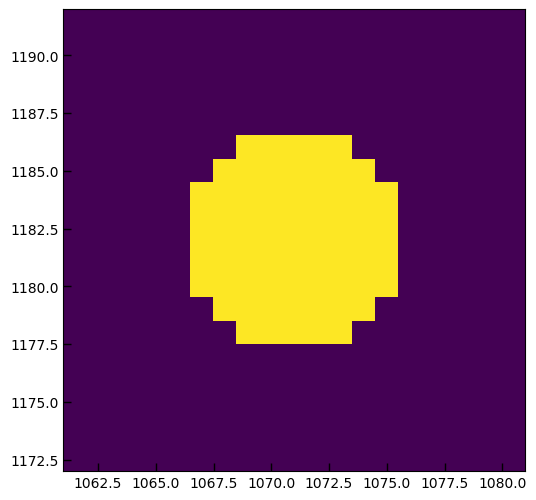

In [68]:
# Create a crude "aperture" for photometry
xsrc, ysrc = 1071, 1182.
yp, xp = np.indices((2048, 2048))

x_cr, y_cr = 1084, 1203

Rsrc = np.sqrt((xp-xsrc)**2 + (yp-ysrc)**2)
Rbkg = np.sqrt((xp-xsrc+10)**2 + (yp-ysrc)**2)
Rcr = np.sqrt((xp-x_cr+10)**2 + (yp-y_cr)**2)

aper_src = Rsrc < 5
aper_bkg = Rbkg < 5
aper_cr = Rcr < 5

plt.imshow(aper_src)
plt.xlim(xsrc - 10, xsrc+10)
plt.ylim(ysrc - 10, ysrc+10)

Text(0, 0.5, 'raw counts')

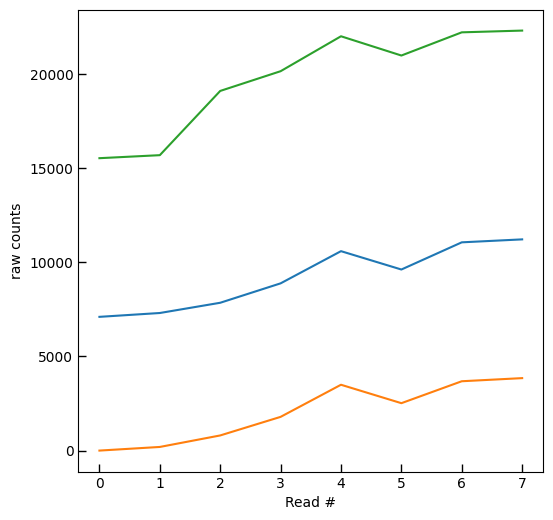

In [69]:
src_flux = np.squeeze(np.nansum(group.data * aper_src, axis=(2, 3)))
bkg_flux = np.squeeze(np.nansum(group.data * aper_bkg, axis=(2, 3)))
cr_flux = np.squeeze(np.nansum(group.data * aper_cr, axis=(2, 3)))

plt.plot(src_flux - bkg_flux[0])
plt.plot(bkg_flux - bkg_flux[0])

plt.plot(cr_flux - bkg_flux[0])

plt.xlabel('Read #')
plt.ylabel('raw counts')

## Find saturated pixels for Persistence masking

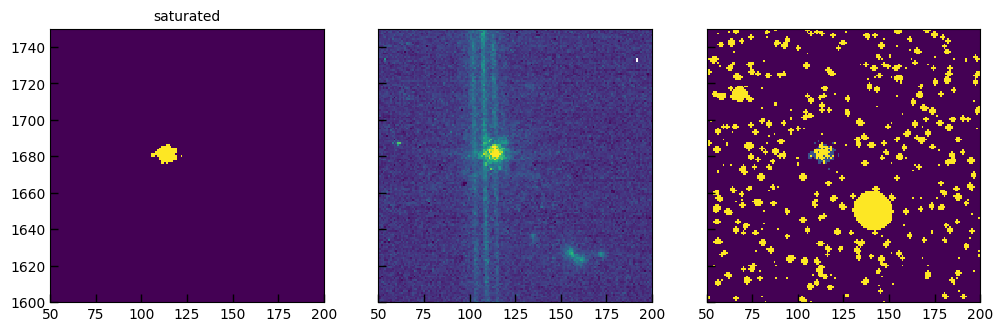

In [78]:
saturation_level = 2**16 - 1024*8

maxval = np.squeeze(np.nanmax(group.data, axis=1))
is_saturated = maxval > saturation_level

next_cal_file = os.path.basename(mast[subset]['dataURI'][1])
next_im = pyfits.open(next_cal_file)

fig, axes = plt.subplots(1,3,figsize=(12,4), sharex=True, sharey=True)

ax = axes[0]
ax.imshow(is_saturated*1)
ax.set_xlim(50, 200)
ax.set_ylim(1600, 1750)
ax.set_title('saturated')

ax = axes[1]
ax.imshow(next_im['SCI'].data, vmin=0.1, vmax=0.5)

ax = axes[2]
ax.imshow(next_im['DQ'].data, vmin=0, vmax=4)

In [79]:
# Update the DQ array of the second exposure with DQ = 1 "DO_NOT_USE"
with pyfits.open(next_cal_file, mode='update') as im:
    im['DQ'].data |= (is_saturated * 1).astype(im['DQ'].data.dtype)
    im.flush()

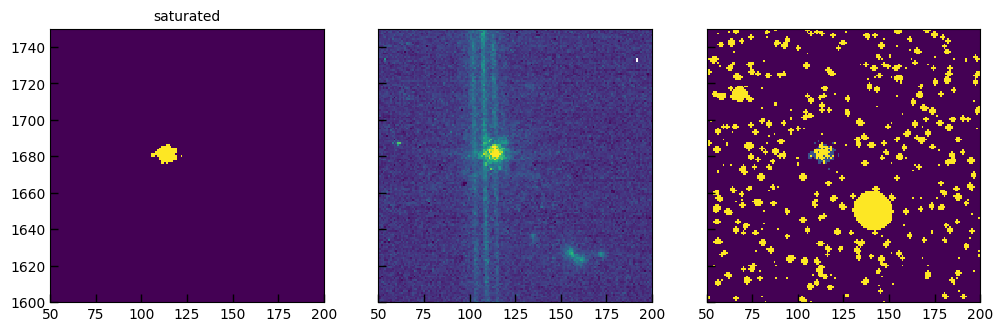

In [80]:
fig, axes = plt.subplots(1,3,figsize=(12,4), sharex=True, sharey=True)

ax = axes[0]
ax.imshow(is_saturated*1)
ax.set_xlim(50, 200)
ax.set_ylim(1600, 1750)
ax.set_title('saturated')

ax = axes[1]
ax.imshow(next_im['SCI'].data, vmin=0.1, vmax=0.5)

ax = axes[2]
ax.imshow(next_im['DQ'].data, vmin=0, vmax=4)

## Make a Level3 mosaic from a list of cal files

In [ ]:
import os
import glob

import numpy as np
import astropy.io.fits as pyfits

from jwst import datamodels
from jwst.associations import asn_from_list  # Tools for creating association files
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base  # Definition of a Lvl3 association file
from jwst.pipeline import Image3Pipeline


cal_files = glob.glob("jw02736*b3*_cal.fits")
cal_files.sort()
# cal_files = cal_files[:3]

sw_product_name = 'smacs0723_f200w'

sw_association = asn_from_list.asn_from_list(cal_files,
                                             rule=DMS_Level3_Base,
                                             product_name=sw_product_name)

sw_association.data['asn_type'] = 'image3'
program = datamodels.open(cal_files[0]).meta.observation.program_number
sw_association.data['program'] = program

# Format association as .json file
sw_asn_filename, sw_serialized = sw_association.dump(format="json")

# Write out association file
sw_association_im3 = os.path.join('./', sw_asn_filename)
with open(sw_association_im3, "w") as fd:
    fd.write(sw_serialized)
    
    
###
image3dict = {}
image3dict['assign_mtwcs'], image3dict['tweakreg'], image3dict['skymatch'] = {}, {}, {}
image3dict['outlier_detection'], image3dict['resample'], image3dict['source_catalog'] = {}, {}, {}

image3_dir = "./"

sw_i2d_result = Image3Pipeline.call(sw_association_im3, output_dir=image3_dir, steps=image3dict, save_results=True)



2025-06-03 15:08:42,606 - CRDS - INFO -  Calibration SW Found: jwst 1.18.0 (/Users/gbrammer/miniconda3/envs/py311-2025/lib/python3.11/site-packages/jwst-1.18.0.dist-info)
2025-06-03 15:08:43,384 - stpipe - INFO - PARS-TWEAKREGSTEP parameters found: /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nircam/jwst_nircam_pars-tweakregstep_0036.asdf
2025-06-03 15:08:43,393 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nircam/jwst_nircam_pars-resamplestep_0001.asdf
2025-06-03 15:08:43,400 - stpipe - INFO - PARS-SOURCECATALOGSTEP parameters found: /Users/gbrammer/Research/grizli/crds_cache/references/jwst/nircam/jwst_nircam_pars-sourcecatalogstep_0007.asdf
2025-06-03 15:08:43,411 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2025-06-03 15:08:43,412 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2025-06-03 15:08:43,414 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRe